## Naive Bees Classifier

### Loading relevent libraries

In [109]:
import pandas as pd
import os, shutil
import numpy as np
from keras.models import Sequential
from keras.utils import np_utils
from keras import layers, models, regularizers, optimizers
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image
from keras.applications import InceptionV3
from keras import backend as K
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score

%matplotlib inline

### Prepairing Image Data

In [65]:
train_labels = pd.read_csv('dataset/train_labels.csv')
train_labels.head()

,id,genus
0,520,1.0
1,3800,1.0
2,3289,1.0
3,2695,1.0
4,4922,1.0


In [66]:
train_labels.genus = train_labels.genus.astype('int64')
print(train_labels.shape)
train_labels.genus.value_counts()

(3969, 2)


1    3142
0     827
Name: genus, dtype: int64


We can see that the dataset is quite imbalanced with a ***20:80 split *** between the two classes. If a guess of 1 is made then 80 % of the times it will be correct, on the other hand it is 20 % for 0.



We will split the train data in 3 parts *** train set, validation set and test set***. The test set will be 10 % of the train data. We will use K-Fold cross validation on the other 90 % of the data left.

In [67]:
original_dataset_dir = 'dataset/'
base_dir_train = 'images/train/'
base_dir_test = 'images/test/'

train_set_split = os.path.join(original_dataset_dir,'train_set')
test_set_split = os.path.join(original_dataset_dir,'test_set')
val_set_split = os.path.join(original_dataset_dir,'val_set')

We have defined 3 function below which are transfer files, cross validation and make k folders below. These 3 fucntion take the splits number and total splits as the arguemnt and divide the train data in 3 parts train set validation set and test set.

In [68]:
def transfer_files(dest, files, cat):
    if cat == 0:
        dest = os.path.join(dest + '/0')
    elif cat == 1:
        dest = os.path.join(dest + '/1')
    else:
        print('Wrong category argument')
    
    for file in files:
        filename = str(file) + '.jpg'
        if os.path.isfile(original_dataset_dir + base_dir_train  + filename):
            shutil.copy(os.path.join(original_dataset_dir + base_dir_train + filename), os.path.join(dest + '/' + filename))
        else:
            print('File missing! : ',filename)
    

In [69]:
def cross_validation(k_i, splits):
    train_files_0s = list(train_labels[train_labels.genus == 0].id)
    train_files_1s = list(train_labels[train_labels.genus == 1].id)
    
    train_subset_0s = train_files_0s[:int(0.9 * len(train_files_0s))]
    train_subset_1s = train_files_1s[:int(0.9 * len(train_files_1s))]
    
    factor = 1 / splits

    train_set_0s = train_files_0s[:int(factor * k_i * len(train_subset_0s))] + train_files_0s[int(factor*(1 + k_i) * len(train_subset_0s)):] 
    train_set_1s = train_files_1s[:int(factor * k_i * len(train_subset_1s))] + train_files_1s[int(factor*(1 + k_i) * len(train_subset_1s)):] 

    val_set_0s = train_files_0s[int(factor * k_i * len(train_subset_0s)):int(factor * (1 + k_i) * len(train_subset_0s))]
    val_set_1s = train_files_1s[int(factor * k_i * len(train_subset_1s)):int(factor * (1 + k_i) * len(train_subset_1s))]

    test_set_0s = train_files_0s[int(0.9 * len(train_files_0s)):]
    test_set_1s = train_files_1s[int(0.9 * len(train_files_1s)):]

    transfer_files(train_set_split, train_set_0s, cat=0)
    transfer_files(train_set_split, train_set_1s, cat=1)
    
    transfer_files(val_set_split, val_set_0s, cat=0)
    transfer_files(val_set_split, val_set_1s, cat=1)
    
    transfer_files(test_set_split, test_set_0s, cat=0)
    transfer_files(test_set_split, test_set_1s, cat=1)
    
    print('All file transfers done!')

In [70]:
def make_k_folders(k_i, splits):
    train_set_split = os.path.join(original_dataset_dir,'train_set')
    test_set_split = os.path.join(original_dataset_dir,'test_set')
    val_set_split = os.path.join(original_dataset_dir,'val_set')
    
    categories = [i for i in range(2)]

    if not os.path.exists(train_set_split):
        os.mkdir(train_set_split)
    if not os.path.exists(test_set_split):
        os.mkdir(test_set_split)
    if not os.path.exists(val_set_split):
        os.mkdir(val_set_split)
    
    for i in categories:
        train_set_split_cat = 'dataset/train_set/' + str(i)
        test_set_split_cat = 'dataset/test_set/' + str(i)
        val_set_split_cat = 'dataset/val_set/' + str(i)
    
        if not os.path.exists(train_set_split_cat):
            os.mkdir(train_set_split_cat)
        if not os.path.exists(test_set_split_cat):
            os.mkdir(test_set_split_cat)
        if not os.path.exists(val_set_split_cat):
            os.mkdir(val_set_split_cat)
        
    cross_validation(k_i, splits)

### CNN Network

We will be using keras for building and trainig our CNN. We will be uisng F1 score as a metric for scores instead of AUC-ROC because keras doesn't support batch by batch AUC-ROC calculation.You can do it at the end of epoch instead. But these metrics are quite similar

In [71]:
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Since the given dataset is quite small(3969 labelled images) we will use pre trained top layers of CNN model InceptionV3 which was trained on imagenet dataset which has millions of images. 
If we try to train our own network it will miss out on important features, exhausting the full dataset.
Luckily imagenet has images for bees which will help us in identifying the basic lower level features.

In [72]:
# Hyper-parameters for CNN

conv_base = InceptionV3(weights='imagenet',include_top=False,input_shape=(200, 200, 3))
conv_base.trainable = False

epochs = 30
learning_rate = 0.00005
adam = optimizers.Adam(lr=learning_rate)

batch_size = 32

In [73]:
def build_model():
    model = Sequential()
    
    model.add(conv_base)
    model.add(Dropout(0.5))
    model.add(layers.Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer = adam, metrics=['binary_accuracy',f1_score])
    
    return model

In [74]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 4, 4, 2048)        21802784  
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               8388864   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 30,191,905
Trainable params: 8,389,121
Non-trainable params: 21,802,784
_________________________________________________________________


#### Data Augmentation

We will be using data augmentation on train set as well as validation set bacause we are using K-Fold cross validation. It is to make sure that the model does't see the same data twice. Also keras model keep a memory of the previous data even if they are run in loop unlike sklearn libraries.

In [75]:
# Hyper-parameter for k-Fold
splits = 5


for i in range(splits):
    try:
        shutil.rmtree('dataset/train_set')
    except:
        print('No train set')
    try:
        shutil.rmtree('dataset/val_set')
    except:
        print('No val set')
    try:
        shutil.rmtree('dataset/test_set')
    except:
        print('No test set')
    
    make_k_folders(i,splits)
    
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

    val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
    
    trgt_train_dir = 'dataset/train_set'
    trgt_val_dir = 'dataset/val_set'

    train_generator = train_datagen.flow_from_directory(
    trgt_train_dir,
    target_size=(200,200),
    batch_size=batch_size,
    class_mode='binary')

    validation_generator = val_datagen.flow_from_directory(
    trgt_val_dir,
    target_size=(200,200),
    batch_size=batch_size,
    class_mode='binary')
    
    history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator)  


All file transfers done!
Found 3256 images belonging to 2 classes.
Found 713 images belonging to 2 classes.
Epoch 1/30
102/102 [==============================] - 60s 589ms/step - loss: 0.5046 - binary_accuracy: 0.7847 - f1_score: 0.8691 - val_loss: 0.7413 - val_binary_accuracy: 0.7952 - val_f1_score: 0.8832
Epoch 2/30
102/102 [==============================] - 42s 411ms/step - loss: 0.4366 - binary_accuracy: 0.8027 - f1_score: 0.8803 - val_loss: 0.4591 - val_binary_accuracy: 0.8149 - val_f1_score: 0.8901
Epoch 3/30
102/102 [==============================] - 42s 409ms/step - loss: 0.4050 - binary_accuracy: 0.8150 - f1_score: 0.8875 - val_loss: 0.4520 - val_binary_accuracy: 0.8149 - val_f1_score: 0.8857
Epoch 4/30
102/102 [==============================] - 42s 410ms/step - loss: 0.3967 - binary_accuracy: 0.8240 - f1_score: 0.8929 - val_loss: 0.4546 - val_binary_accuracy: 0.8008 - val_f1_score: 0.8769
Epoch 5/30
102/102 [==============================] - 42s 407ms/step - loss: 0.3856 - bi

102/102 [==============================] - 41s 403ms/step - loss: 0.2933 - binary_accuracy: 0.8665 - f1_score: 0.9167 - val_loss: 0.5318 - val_binary_accuracy: 0.8322 - val_f1_score: 0.9000
Epoch 21/30
102/102 [==============================] - 41s 403ms/step - loss: 0.2984 - binary_accuracy: 0.8632 - f1_score: 0.9153 - val_loss: 0.4250 - val_binary_accuracy: 0.8392 - val_f1_score: 0.9041
Epoch 22/30
102/102 [==============================] - 42s 416ms/step - loss: 0.2991 - binary_accuracy: 0.8729 - f1_score: 0.9216 - val_loss: 0.4325 - val_binary_accuracy: 0.8517 - val_f1_score: 0.9117
Epoch 23/30
102/102 [==============================] - 42s 408ms/step - loss: 0.2949 - binary_accuracy: 0.8648 - f1_score: 0.9161 - val_loss: 0.4050 - val_binary_accuracy: 0.8448 - val_f1_score: 0.9073
Epoch 24/30
102/102 [==============================] - 41s 403ms/step - loss: 0.2975 - binary_accuracy: 0.8682 - f1_score: 0.9179 - val_loss: 0.4429 - val_binary_accuracy: 0.8462 - val_f1_score: 0.9087
Ep

In [76]:
model.save('pd_v1.h5')

Accuracy and loss is plotted only for last epoch.

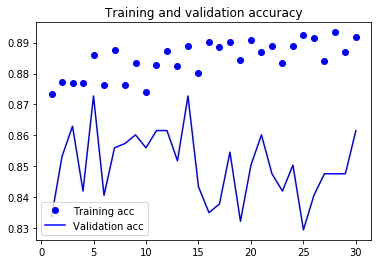

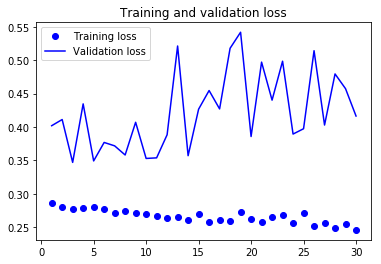

In [79]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Prediction for Test Set and AUC-ROC Score

In [97]:
test_list_0s = [f for f in os.listdir('dataset/test_set/0')]
test_list_1s = [f for f in os.listdir('dataset/test_set/1')]

In [98]:
test_df = pd.DataFrame(0, index = np.arange(len(test_list_0s) + len(test_list_1s)), columns=['image','y_true','y_predict'])
test_df.head()

,image,y_true,y_predict
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [99]:
test_df.image = test_list_0s + test_list_1s
for i, row in test_df.iterrows():
    if row.image in test_list_0s:
        test_df.at[i, 'y_true'] = 0
    else:
        test_df.at[i, 'y_true'] = 1

In [100]:
for i, row in test_df.iterrows():
    if row.y_true == 0:
        img_path = os.path.join('dataset/test_set/0/' + str(row.image))
    else:
        img_path = os.path.join('dataset/test_set/1/' + str(row.image))
    
    img = image.load_img(img_path, target_size=(200, 200))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255.
    pred = model.predict_classes(img_tensor)
    test_df.at[i, 'y_predict'] = pred

#### Scores on test set without data augmentation
The following blocks show scores for test set on metrics such as roc-auc, f1-score, accuracy

In [101]:
roc_auc_score(test_df.y_true, test_df.y_predict)

0.7542359915853891

In [110]:
f1_score(test_df.y_true, test_df.y_predict)

0.911353032659409

In [111]:
accuracy_score(test_df.y_true, test_df.y_predict)

0.8567839195979899

### Predict for Test

In [112]:
test_files = [f for f in os.listdir('dataset/images/test')]
submit_df = pd.DataFrame(0, index=np.arange(len(test_files)), columns=['id','genus'])

In [113]:
submit_df.id = test_files

In [114]:
for i,row in submit_df.iterrows():
    img_path = os.path.join('dataset/images/test/' + str(row.id))    
    img = image.load_img(img_path, target_size=(200, 200))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255.
    pred = model.predict_classes(img_tensor)
    submit_df.at[i,'genus'] = pred

In [115]:
for i, row in submit_df.iterrows():
    submit_df.at[i,'id'] = row.id.split('.')[0]

In [116]:
submit_df.to_csv('submission.csv', index=False)

In [118]:
submit_df.genus.value_counts()

1    838
0    154
Name: genus, dtype: int64

The only think we can infer after looking at the test data predictions is that the classes retain similar ratio to that of train data.

### Conclusion
There are several things that can be done to improve accuracy.

*** Hyperparameter tuning*** 

*** Ensembling ***

I will conclude here because my AWS bills are going a bit high side.